# Energy Balances II

This lecture begins with example problems using Energy Balances.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Brief Review of the Need For Energy Balances

Until now, we've always considered isothermal reactors.  We have often considered the effect of changing temperature on a rate constant, but as far as the reactor is concerned, we have always assumed that the entire reactor exists at a single temperature that is equal to the temperature at the start of the run (in a batch reactor) or the temperatuer of the feed (in a flow reactor).  These would be *isothermal* reactors.

We know after courses in mass and energy balances and thermodynamics that most reactions are not thermoneutral.  This means that most reactions have a non-zero heat of reaction ($\Delta H$), so they will either release energy to or absorb energy from the environment.  As this happens, we should anticipate that the temperature inside of the reactor may change considerably. From a strict chemistry standpoint, this is important for two reasons:

1. Rate constants have an exponential dependence on temperature
2. Equilibrium constants have an exponential dependence on temperature

In other words, changing the reaction temperature over the course of reaction progress can dramatically impact how favorable reaction is (thermodynamics, equilibrium constant) and how fast the reaction occurs (kinetics, rate constant).  So it is extremely important that we understand how to anticipate changes in temperature as a function of reaction progress, reaction time, and/or reactor size.  We do this by writing energy balances on the reactor of interest.  We can use the same basic concept that we did for material balances -- we envision a shell balance on the reactor, and we consider the energy entering, leaving, and accumulating in that control volume.

If you are interested in the derivation of the reactor energy balances starting from a shell balance, please see Lecture 39, where the steps are outlined in detail. It is rare that we will need to go back to the starting point in general, and in all problems we will consider this semester, we will only work with the following, useful forms of the energy balance.

## Energy Balances for Ideal Reactor Archetypes in 587

### Batch Reactor

The material balance for species j in a well-mixed batch reactor is:

$$\frac{dN_j}{dt} = R_jV$$

In cases where we have either an incompressible fluid or our reactor operates at constant pressure, the energy balance on a batch reactor is:

$$\sum_j N_j \bar{C}_{p,j} \frac{dT}{dt} = -\sum_i \Delta H_{i} r_i V + \dot{Q}$$

A few notation conventions:  the bar over a property here means it is an intensive molar property for a species and it has units of "per mole".  $\dot{Q}$ is the rate of heat exhange with the surroundings.  It is given by:

$$\dot{Q} = UA(T_a - T)$$

Where $U$ is an overall heat transfer coefficient, $A$ is the heat exchange area, and $T_a$ is the temperature of the heat exchange fluid.

### CSTR

The material balance for species j in a CSTR is:

$$\frac{dN_j}{dt} = F_{jf} - F_j + R_jV$$

If we have an incompressible fluid or a reactor operating at constant pressure, the energy balance on a CSTR is:

$$\sum_j N_j \bar{C}_{p,j} \frac{dT}{dt} = -\sum_i \Delta H_{i} r_i V + \sum_j F_{jf}(\bar{H}_{jf} - \bar{H}_j) + \dot{Q}$$

The rate of heat exchange is the same as in a batch reactor:

$$\dot{Q} = UA(T_a - T)$$

### PFR

The material balance for species j in a PFR is:

$$\frac{dF_j}{dV} = R_j$$

If we have an ideal gas or a reactor operating without a pressure drop, the energy balance for a PFR is:

$$\sum_j F_j \bar{C}_{p,j} \frac{dT}{dV} = -\sum_i \Delta H_{i} r_i + \dot{q}$$

For a PFR, we express the rate of heat transfer per unit volume, and it has a symbol $\dot{q}$:

$$\dot{q} = Ua(T_a - T)$$

$U$ is an overall heat transfer coefficient as usual, and $a$ is the ratio of surface area to volume for the reactor.  For a tube, this is usually given as:

$$a = \frac{2}{R}$$

## Example Problem 01

The exothermic elementary liquid-phase reaction (Rawlings and Ekerdt, E6.1):

$$A + B \longrightarrow C$$

is carried out in a batch reactor equipped with a cooling coil such that you can vary conditions between isothermal and adiabatic.  The reactor is initially charged with equal concentrations of A and B at 27$^\circ$C (300K), and both of their concentrations are 2.0 mol/L. The reaction is irreversible, and it is first order with respect to both A and B.

$$r = k C_A C_B$$

The rate constant can be computed from the following equation:

$$k = k_0 \cdot exp\left(\frac{-E_A}{R}\left(\frac{1}{T}-\frac{1}{T_0}\right)\right)$$

where: $k_0 = 0.01725 \, \textrm{L} \, \textrm{mol}^{-1} \, \textrm{min}^{-1} \textrm{at 300K and} \frac{E_A}{R} = 2660 \textrm{K}$

You additionally have the following data:

\begin{align}		
    \Delta H_{rxn} &= -10 \ \textrm{kcal} \ \textrm{mol}^{-1} \\
    C_{PA} &= 20 \ \textrm{cal} \ \textrm{mol}^{-1} \ \textrm{K}^{-1} \\
    C_{PB} &= 20 \ \textrm{cal} \ \textrm{mol}^{-1} \ \textrm{K}^{-1} \\
    C_{PC} &= 40 \ \textrm{cal} \ \textrm{mol}^{-1} \ \textrm{K}^{-1} \\
    V &= 1200 \ \textrm{L}
\end{align}

If the reactor operates isothermally at 300K, how long does it take to achieve 95\% conversion of species A? Plot XA and rate vs time for this solution.

### Solution to Example Problem 01

This is a problem we are already familiar with.  We'd like to solve for the time required to achieve a specific conversion in a well-mixed batch reactor.  There are many paths we can take, but they all involve writing material balances.  My approach here will be to write balances on all species and integrate the coupled system of ODEs numerically using solve_ivp.

\begin{align}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV \\
    \frac{dN_C}{dt} = R_CV
\end{align}

We can express production rates in terms of the reaction rate:

\begin{align}
    R_A &= -r \\
    R_B &= -r \\
    R_C &= r
\end{align}

This reaction follows elementary kinetics, so the rate law is:

$$r = k C_A C_B$$

We are solving ODEs in the time domain with 3 state (dependent) variables: NA, NB, and NC.  I can express my concentrations in terms of these quantities:

\begin{align}
    C_A = \frac{N_A}{V} \\
    C_B = \frac{N_B}{V}
\end{align}

And we know the rate constant for this system.  Since it is isothermal at 300K, the rate constant is always equal to the rate constant at 300K:

$$k = k_0 = 0.01725 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{min}^{-1}$$

That is everything we need to solve using an ODE solver; see cell below.

For isothermal operation at 300K, it will take 551 minutes to achieve 95% conversion


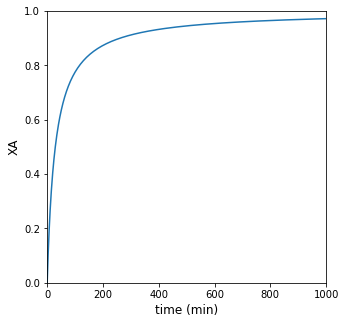

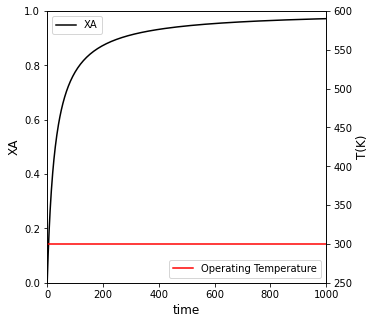

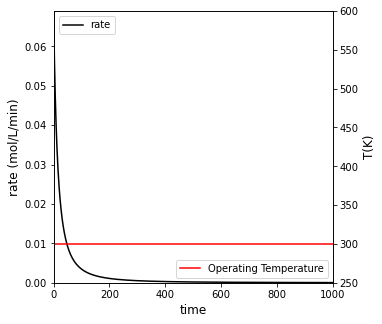

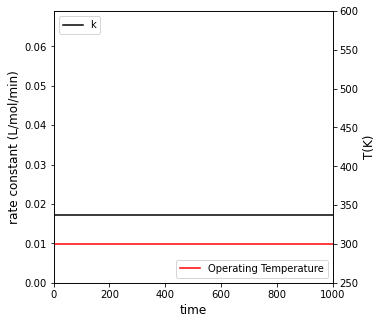

In [2]:
def isothermal(t, var):
    NA = var[0]
    NB = var[1]
    NC = var[2]
    V  = 1200 #L
    
    CA = NA/V
    CB = NB/V
    CC = NC/V
    
    k0 = 0.01725 #L/mol/min
    
    r  = k0*CA*CB
    RA = -r
    RB = -r
    RC =  r
    
    D1 = RA*V
    D2 = RB*V
    D3 = RC*V
    return [D1, D2, D3]

##problem statement information
k0    = 0.01725 #L/mol/min
V0    = 1200
CA0   = 2.0 #mol/L
CB0   = 2.0 #mol/L
CC0   = 0.0
NA0   = CA0*V0
NB0   = CB0*V0
NC0   = CC0*V0

#set up IVP solver, solve problem
N0    = [NA0, NB0, NC0]
tspan = (0.0, 1000.0)
ansa  = solve_ivp(isothermal, tspan, N0, atol = 1e-10, rtol = 1e-10)

#Workup solution to get requested quantities
t     = ansa.t
NA    = ansa.y[0,:]
NB    = ansa.y[1,:]
CA    = NA/V0
CB    = NB/V0
XA    = (NA0 - NA)/NA0
r     = k0*CA*CB

T_iso = np.zeros(len(t)) + 300
k     = np.zeros(len(t)) + k0

itpa  = interp1d(XA, t, kind = 'cubic')
tsola = itpa(0.95)
print(f'For isothermal operation at 300K, it will take {tsola:3.0f} minutes to achieve 95% conversion')

##Plot of conversion vs. time
plt.figure(1, figsize = (5, 5))
plt.plot(t, XA)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('XA', fontsize = 12)
plt.xlim(0, max(tspan))
plt.ylim(0, 1)
plt.show()

##Create plot with 2 yaxes to plot Conversion and Temperature vs. time
fig1, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
conv = ax1.plot(t, XA, color = 'black', label = 'XA')
temp = ax2.plot(t, T_iso, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, 1)
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('XA', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

##Create a plot with two y axes to show rate and temperature vs. time
fig2, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
rate = ax1.plot(t, r, color = 'black', label = 'rate')
temp = ax2.plot(t, T_iso, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, max(r))
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('rate (mol/L/min)', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

##Create a plot with two y axes to show rate constant and temperature vs. time
fig3, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
cons = ax1.plot(t, k, color = 'black', label = 'k')
temp = ax2.plot(t, T_iso, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, max(r))
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('rate constant (L/mol/min)', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

## Example Problem 02

If the reactor operates ***adiabatically***, what is the maximum temperature that the reactor can reach during operation? 

### Solution to Example Problem 02

We'll start this with the energy balance on the batch reactor:

$$\sum_j N_j \bar{C}_{p,j} \frac{dT}{dt} = -\sum_i \Delta H_i r_i V + \dot{Q}$$

First, some simplifications that are specific to this problem.  It is adiabatic, so we know there is no heat exchange with the surroundings, and $\dot{Q} = 0$.  Second, there is only one reaction involved so the summation term involving heats of reaction involves only one term.

$$\sum_j N_j \bar{C}_{p,j} \frac{dT}{dt} = -\Delta H r V$$

We'll expand the summation of species on the left hand side:

$$\left(N_A \bar{C}_{p,A} + N_B \bar{C}_{p,B} + N_C \bar{C}_{p,C}\right) \frac{dT}{dt} = -\Delta H r V$$

And I'll go ahead and move that summation to the right hand side; this is our starting point for this particular problem:

$$\frac{dT}{dt} = \frac{-\Delta H r V}{N_A \bar{C}_{p,A} + N_B \bar{C}_{p,B} + N_C \bar{C}_{p,C}} $$

We could actually solve this as is by combining it with material balances on A, B, and C (see Example Problem 03 below), but the problem statement does not ask us anything about how long it takes to achieve a maximum temperature increase, it only asks what the maximum temperature increase is.  This means we don't really need to integrate the problem in the time domain, we are really only interested in the increase in temperature as a function of reaction progress.  Clearly, the further this exothermic reaction goes toward completion ($X_A = 1$), the higher the temperature will increase. The relationship between temperature and conversion in an adiabatic process is usually called the "adiabatic temperature change" for a reaction, and it is a very important quantity for us to be able to estimate.  To facilitate an analytical solution, we'd like to reduce this to a single ODE instead of having to solve multiple, coupled ODEs.  We do this by substituting a material balance into the energy balance.

Specifically, if we write a balance on species A, we find:

$$\frac{dN_A}{dt} = -rV$$

We can express $N_A$ as a function of fractional conversion:

$$N_A = N_{A0} - N_{A0}X_A$$

Substituting this into the material balance above, we get:

$$N_{A0}\frac{dX_A}{dt} = rV$$

We see that the rV product appears in our energy balance, so we'll substitue this into the EB to get:

$$\frac{dT}{dt} = \frac{-\Delta H N_{A0}}{N_A \bar{C}_{p,A} + N_B \bar{C}_{p,B} + N_C \bar{C}_{p,C}}\frac{dX_A}{dt} $$

We can multiply both sides by $dt$, which converts this from an ODE that describes how temperature changes with time to one that describes how temperature changes with fractional conversion of A:

$$dT = \frac{-\Delta H N_{A0}}{N_A \bar{C}_{p,A} + N_B \bar{C}_{p,B} + N_C \bar{C}_{p,C}} dX_A $$

That almost looks like an equation we can solve, but it isn't 100% clear that it is a separable ODE just yet.  Specifically, I know for sure that $N_A$, $N_B$, and $N_C$ depend on $X_A$, so we need to specify that dependence before we can integrate the right hand side.  Furthermore, I know that heat capacities and heats of reaction will generally change with temperature, so I need to figure out those functional dependencies and determine whether or not they need to be integrated with respect to temperature and/or conversion.

We'll do this term by term.

First, in the problem statement, we are given heat capacities for each species.  They are all clearly constant.  They are temperature independent, so we can be confident that each heat capacity in the above ODE is a constant.

Now we address the heat of reaction, which we always expect to change with temperature.

$$\Delta H(T) = \Delta H^\circ + \int_{T_0}^{T} \Delta C_p dT$$

Whether or not the heat of reaction changes with temperature depends on the value of $\Delta C_p$ for that reaction.  We define the $\Delta C_p$ for reaction $i$ as:

$$\Delta C_{p,i} = \sum_j \nu_{i,j} C_{p,j}$$

For this problem:

$$\Delta C_p = C_{p,C} - C_{p,A} - C_{p,B}$$

Substituting numbers:

$$\Delta C_p = \big[40 - 20 - 20\big] \ \textrm{cal} \ \textrm{mol}^{-1} \ \textrm{K}^{-1}$$

Thus, for this specific case:

$$\Delta C_p = 0$$

And:

$$\Delta H(T) = \Delta H^\circ = -10 \ \textrm{kcal} \ \textrm{mol}^{-1} \ \textrm{K}^{-1}$$

Next, we'll look at the summation of molar quantities multiplied by heat capacities:

$$\sum_j N_j \bar{C}_{p,j} = N_A \bar{C}_{p,A} + N_B \bar{C}_{p,B} + N_C \bar{C}_{p,C}$$

We'll express everything on the right hand side as a function of fractional conversion; this is based on a mole table, from which we get:

\begin{align}
    N_A = N_{A0} - N_{A0}X_A \\ 
    N_B = N_{B0} - N_{A0}X_A \\
    N_C = N_{C0} + N_{A0}X_A \\
\end{align}

Substituting these into that summation term:

\begin{align}
    \sum_j N_j \bar{C}_{p,j} = &N_{A0}\bar{C}_{p,A} - \bar{C}_{p,A}N_{A0}X_A\\ 
    + &N_{B0}\bar{C}_{p,B} - \bar{C}_{p,B}N_{A0}X_A \\
    \\
    + &N_{C0}\bar{C}_{p,C} + \bar{C}_{p,C}N_{A0}X_A \\
\end{align}

We can simplify that using summation notation:

$$\sum_j N_j \bar{C}_{p,j} = \sum_j N_{j0} \bar{C}_{p,j} + N_{A0}X_A\sum_j \nu_j \bar{C}_{p,j}$$

And the summation on the right hand side is just the $\Delta C_p$ for this reaction, so:

$$\sum_j N_j \bar{C}_{p,j} = \sum_j N_{j0} \bar{C}_{p,j} + \Delta C_p N_{A0}X_A$$

For this specific reaction, we have proven that $\Delta C_p = 0$, so:

$$\sum_j N_j \bar{C}_{p,j} = \sum_j N_{j0} \bar{C}_{p,j}$$

In other words, this summation on the left hand side is dependent only on the initial numbers of moles in the system, and it is not a function of fractional conversion:

$$\sum_j N_j \bar{C}_{p,j} = N_{A0} \bar{C}_{p,A} + N_{B0} \bar{C}_{p,B}$$

With all of this, we return to our ODE and make appropriate substitutions:

$$dT = \frac{-\Delta H N_{A0}}{N_{A0} \bar{C}_{p,A} + N_{B0} \bar{C}_{p,B}} dX_A $$

All of the terms before $dX_A$ on the right hand side are constants.  They depend neither on $X_A$ or $T$, so we can easily solve the integral:

$$\int_{T_0}^T dT = \int_{0}^{X_A} \frac{-\Delta H N_{A0}}{N_{A0} \bar{C}_{p,A} + N_{B0} \bar{C}_{p,B}} dX_A $$

Because everything on the right hand side is constant, this becomes:

$$\int_{T_0}^T dT = \frac{-\Delta H N_{A0}}{N_{A0} \bar{C}_{p,A} + N_{B0} \bar{C}_{p,B}} \int_{0}^{X_A} dX_A $$

And the integral evaluation is straightforward:

$$(T - T_0) = \frac{-\Delta H N_{A0}}{N_{A0} \bar{C}_{p,A} + N_{B0} \bar{C}_{p,B}} X_A$$

The maximum temperature increase occurs when the reaction reaches completion at $X_A = 1$; plugging this and values from the problem statment into the solution, we find that:

$$(T - T_0)_\textrm{max} = 250 \textrm{K}$$

## Example Problem 03

If the reactor operates adiabatically, how long does it take to reach 95\% conversion?  Plot $X_A$, $T$, and rate vs time for this case. Compare your result to isothermal operation at 300K

### Solution to Example Problem 03

Here, we have to work in the time domain; the problem asks how long it will take to achieve a certain conversion.  We approach this *almost* identically to part A.  We start by writing material balances:

\begin{align}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV \\
    \frac{dN_C}{dt} = R_CV
\end{align}

We can express production rates in terms of the reaction rate:

\begin{align}
    R_A &= -r \\
    R_B &= -r \\
    R_C &= r
\end{align}

This reaction follows elementary kinetics, so the rate law is:

$$r = k C_A C_B$$

We are solving ODEs in the time domain with 3 state (dependent) variables: NA, NB, and NC.  I can express my concentrations in terms of these quantities:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V
\end{align}

The only difference between this and part A is that the reaction temperature is changing (since the reactor is adiabatic).  For that reason, the rate constant is changing as a function of time.  It is no longer fixed, so we need a framework to calculate it as reaction time changes.  We have an expression for the rate constant given in the problem statement:

$$k = k_0\exp\left[-\frac{E_A}{R}\left(\frac{1}{T} - \frac{1}{T_0}\right)\right]$$

Almost everything is given in the problem statement.  We know EA/R, $k_0$, and $T_0$.  The only thing we don't know yet is the reaction temperature.  It is changing as a function of time, so we need to write the energy balance to account for this.

$$\sum_j N_j \bar{C}_{p,j} \frac{dT}{dt} = -\sum_i \Delta H_i r_i V + \dot{Q}$$

We start by setting $\dot{Q} = 0$ since this reaction is adiabatic.  We also recognize that we only have a single reaction.  Finally, this system involves 3 species: A, B, and C, so we can expand the summation term on the left hand side.  This balance simplifies to:

$$\frac{dT}{dt} = \frac{-\Delta H r V}{N_A \bar{C}_{p,A} + N_B \bar{C}_{p,B} + N_C \bar{C}_{p,C}} $$

That may look a little new, but it's fairly straightforward.  It's a fourth time-domain differential equation that is coupled to the balances on A, B, and C.  We can solve all four ODEs simultaneously with solve_ivp as usual.  All of the terms on the right hand side are either constant ($\Delta H$, $C_{p,j}$, $V$), or they are being tracked by our ODE solver ($N_A$, $N_B$, and $N_C$). 

We have everything we need to solve the ODE system.  See below.

For adiabatic operation, it will take  20 minutes to achieve 95% conversion


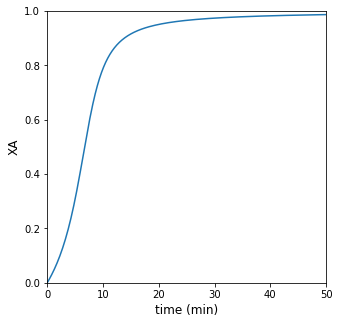

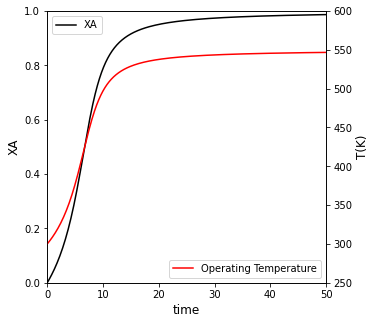

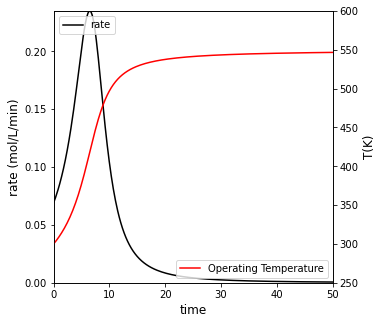

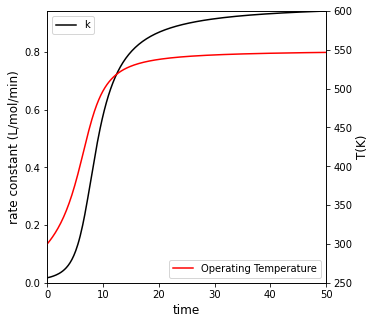

In [3]:
def adiabatic(t, var):
    NA = var[0]
    NB = var[1]
    NC = var[2]
    T  = var[3]
    
    V   = 1200 #L
    EAR = 2660 #K 
    DH  = -10*1000 #cal/mol
    CPA = 20 #cal/mol/K
    CPB = 20 #cal/mol/K
    CPC = 40 #cal/mol/K
    
    CA = NA/V
    CB = NB/V
    CC = NC/V
    
    k0 = 0.01725 #L/mol/min
    k  = k0*np.exp(-EAR*(1/T - 1/T0))
    
    r  =  k*CA*CB
    RA = -r
    RB = -r
    RC =  r
    
    Qdot = 0
    
    D1 = RA*V
    D2 = RB*V
    D3 = RC*V
    DT = (-DH*r*V + Qdot)/(NA*CPA + NB*CPB + NC*CPC)
    return [D1, D2, D3, DT]

##problem statement information
k0    = 0.01725 #L/mol/min
EAR   = 2660 #K
V0    = 1200
CA0   = 2.0 #mol/L
CB0   = 2.0 #mol/L
CC0   = 0.0
NA0   = CA0*V0
NB0   = CB0*V0
NC0   = CC0*V0
T0    = 300 #K

#set up IVP solver, solve problem
var0    = [NA0, NB0, NC0, T0]
tspan = (0.0, 50.0)
ansb  = solve_ivp(adiabatic, tspan, var0, atol = 1e-10, rtol = 1e-10)

#Workup solution to get requested quantities
t     = ansb.t
NA    = ansb.y[0,:]
NB    = ansb.y[1,:]
T     = ansb.y[3,:]
CA    = NA/V0
CB    = NB/V0
XA    = (NA0 - NA)/NA0
k     = k0*np.exp(-EAR*(1/T - 1/T0))
r     = k*CA*CB

itpb  = interp1d(XA, t, kind = 'cubic')
tsolb = itpb(0.95)
print(f'For adiabatic operation, it will take {tsolb:3.0f} minutes to achieve 95% conversion')


##Plot of conversion vs. time
plt.figure(1, figsize = (5, 5))
plt.plot(t, XA)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('XA', fontsize = 12)
plt.xlim(0, max(tspan))
plt.ylim(0, 1)
plt.show()

##Create plot with 2 yaxes to plot Conversion and Temperature vs. time
fig1, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
conv = ax1.plot(t, XA, color = 'black', label = 'XA')
temp = ax2.plot(t, T, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, 1)
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('XA', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

##Create a plot with two y axes to show rate and temperature vs. time
fig2, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
rate = ax1.plot(t, r, color = 'black', label = 'rate')
temp = ax2.plot(t, T, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, max(r))
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('rate (mol/L/min)', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

##Create a plot with two y axes to show rate constant and temperature vs. time
fig3, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
cons = ax1.plot(t, k, color = 'black', label = 'k')
temp = ax2.plot(t, T, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, max(k))
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('rate constant (L/mol/min)', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

## Example Problem 04

Assume the reactor operates nonadiabatically with heat exchange. For this case, UA = 12 kcal/min/K and the temperature of the heat transfer fluid is constant at 300K.  How long does it take to achieve 95\% conversion?  Plot XA, T, and rate vs. time in this reactor; consider the impacts of changing heat transfer rates by adjusting the temperature of the heat transfer fluid or the value of UA (heat transfer coefficient times interfacial area)

### Solution to Example Problem 04

For operation with heat exchange, it will take 455 minutes to achieve 95% conversion


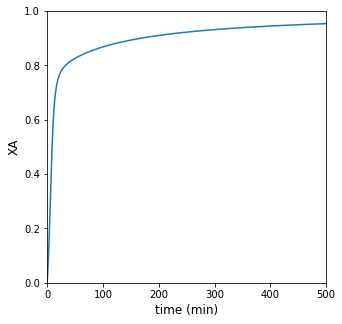

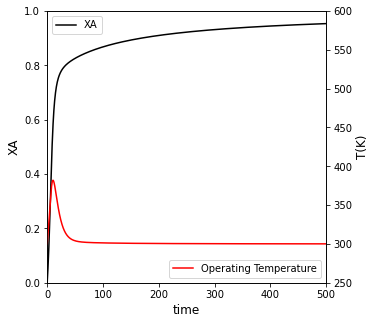

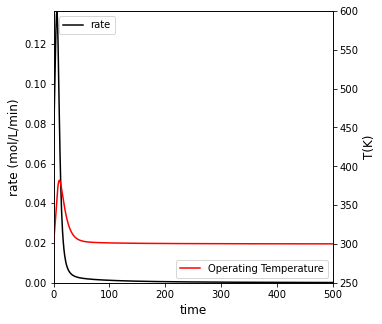

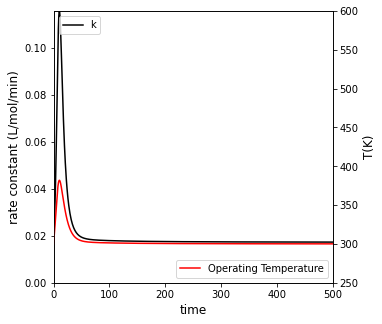

In [4]:
def heatex(t, var):
    NA = var[0]
    NB = var[1]
    NC = var[2]
    T  = var[3]
    
    V   = 1200 #L
    EAR = 2660 #K 
    DH  = -10*1000 #cal/mol
    CPA = 20 #cal/mol/K
    CPB = 20 #cal/mol/K
    CPC = 40 #cal/mol/K
    UA  = 12*1000 #cal/min/K
    Ta  = 300  #K
    
    CA = NA/V
    CB = NB/V
    CC = NC/V
    
    k0 = 0.01725 #L/mol/min
    k  = k0*np.exp(-EAR*(1/T - 1/T0))
    
    r  =  k*CA*CB
    RA = -r
    RB = -r
    RC =  r
    
    Qdot = UA*(Ta - T)
    
    D1 = RA*V
    D2 = RB*V
    D3 = RC*V
    DT = (-DH*r*V + Qdot)/(NA*CPA + NB*CPB + NC*CPC)
    return [D1, D2, D3, DT]


##problem statement information
k0    = 0.01725 #L/mol/min
EAR   = 2660 #K
V0    = 1200
CA0   = 2.0 #mol/L
CB0   = 2.0 #mol/L
CC0   = 0.0
NA0   = CA0*V0
NB0   = CB0*V0
NC0   = CC0*V0
T0    = 300 #K

#set up IVP solver, solve problem
var0    = [NA0, NB0, NC0, T0]
tspan = (0.0, 500.0)
ansc  = solve_ivp(heatex, tspan, var0, atol = 1e-10, rtol = 1e-10)

#Workup solution to get requested quantities
t     = ansc.t
NA    = ansc.y[0,:]
NB    = ansc.y[1,:]
T     = ansc.y[3,:]
CA    = NA/V0
CB    = NB/V0
XA    = (NA0 - NA)/NA0
k     = k0*np.exp(-EAR*(1/T - 1/T0))
r     = k*CA*CB

itpc  = interp1d(XA, t, kind = 'cubic')
tsolc = itpc(0.95)
print(f'For operation with heat exchange, it will take {tsolc:3.0f} minutes to achieve 95% conversion')

##Plot of conversion vs. time
plt.figure(1, figsize = (5, 5))
plt.plot(t, XA)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('XA', fontsize = 12)
plt.xlim(0, max(tspan))
plt.ylim(0, 1)
plt.show()

##Create plot with 2 yaxes to plot Conversion and Temperature vs. time
fig1, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
conv = ax1.plot(t, XA, color = 'black', label = 'XA')
temp = ax2.plot(t, T, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, 1)
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('XA', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

##Create a plot with two y axes to show rate and temperature vs. time
fig2, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
rate = ax1.plot(t, r, color = 'black', label = 'rate')
temp = ax2.plot(t, T, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, max(r))
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('rate (mol/L/min)', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()

##Create a plot with two y axes to show rate constant and temperature vs. time
fig3, ax1 = plt.subplots(figsize = (5, 5))
ax2  = ax1.twinx()
cons = ax1.plot(t, k, color = 'black', label = 'k')
temp = ax2.plot(t, T, color = 'red', label = 'Operating Temperature')
ax1.set_xlim(0, max(tspan))
ax1.set_ylim(0, max(k))
ax2.set_ylim(250, 600)
ax1.set_xlabel('time', fontsize = 12)
ax1.set_ylabel('rate constant (L/mol/min)', fontsize = 12)
ax2.set_ylabel('T(K)', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show()